In [ ]:
import os
import random

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn import linear_model

import xgboost as xgb
from xgboost import XGBRegressor

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RepeatedKFold
from sklearn.model_selection import cross_val_score
from sklearn.metrics import mean_squared_error

In [ ]:
# import libraries
import pandas as pd
import numpy as np

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="ticks")

# import sklearn libararies
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.ensemble import RandomForestRegressor, IsolationForest
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.model_selection import GridSearchCV

from google.colab import files
import io

from google.colab import drive
import zipfile
import os
import cv2

# Import Warnings 
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
from sklearn.utils import shuffle
#from sklearn.cross_validation import train_test_split
# Import tensorflow as the backend for Keras
from sklearn.metrics import classification_report,confusion_matrix
import itertools

import lightgbm as lgb
import pickle

In [ ]:
def find_max_fit_line( x, y, z, tol=0.001 ):    
    reg = LinearRegression()
    
    best_score = 0   
    res_x, res_y, res_z, dis_x, dis_y, dis_z = [], [], [], [], [], []

    for _ in range(13000):
        sampling_idx_list = random.sample(range(len(y)), num_data_points)
        xs_sampled = [x[idx] for idx in sampling_idx_list]
        ys_sampled = [y[idx] for idx in sampling_idx_list]        
        
        reg.fit(xs_sampled, ys_sampled)
        preds = reg.predict( x ) 
        
        diff = np.abs(y - preds)
        match_list = [1 if d < tol else 0 for d in diff]
        score = sum(match_list) / len(diff)

        if score > best_score:
            best_score = score 

            dis_x = [x[idx] for idx, s in enumerate(match_list) if s != 0]
            dis_y = [y[idx] for idx, s in enumerate(match_list) if s != 0]
            dis_z = [z[idx] for idx, s in enumerate(match_list) if s != 0]
            
            res_x = [x[idx] for idx, s in enumerate(match_list) if s == 0]
            res_y = [y[idx] for idx, s in enumerate(match_list) if s == 0]
            res_z = [z[idx] for idx, s in enumerate(match_list) if s == 0]

            print('Best score', score, 'Data points', sum(match_list))
            
    best_reg = LinearRegression()
    best_reg.fit(dis_x, dis_y)
    
    print('m', best_reg.coef_,'c', best_reg.intercept_)
    print()
            
    return res_x, res_y, res_z, dis_x, dis_y, dis_z, best_reg

def create_fit_df( idx, train_df_list_vsh_mod ):
    fit_df = train_df_list_vsh_mod[idx][['GR', 'VSH', 'DEPTH']]
    fit_df = fit_df.dropna()
        
    fit_df = fit_df[fit_df['VSH'] > 0]
    fit_df = fit_df[fit_df['VSH'] < 1]
    
    return fit_df

def plot_scatter_vsh( fit_df ):
    plt.figure(figsize=(8,8))
    plt.scatter(fit_df['GR'], fit_df['VSH'], s=1, c="g")
    plt.xlabel("GR")
    plt.ylabel("VSH")
    plt.show() 
    
def plot_scatter_whole( df ):
    plt.figure(figsize=(8,8))
    plt.scatter(df['GR'], df['VSH'], s=1, c="g")
    plt.xlabel("GR")
    plt.ylabel("VSH")
    plt.show() 
    
def plot_preds( dis_x_list, dis_y_list, best_reg_list, fit_df ):
    plt.figure(figsize=(8,8))
    
    c_list = ['red', 'green', 'blue', 'black', 'purple', 'orange', 'yellow']

    for idx in range(num_lines):
        line_X = np.arange(min([v[0] for v in dis_x_list[idx]]), max([v[0] for v in dis_x_list[idx]]), 1)[:, np.newaxis]
        line_y = best_reg_list[idx].predict(line_X)
        plt.plot(line_X, line_y, color=c_list[idx])

    plt.scatter(fit_df['GR'], fit_df['VSH'], s=1, c="black")

    plt.xlabel("GR")
    plt.ylabel("VSH")
    plt.show()
    
def extract_lines_vsh( fit_df, tol=0.001 ):
    res_x = [[v] for v in fit_df['GR'].values]
    res_y = fit_df['VSH'].values
    res_z = fit_df['DEPTH'].values

    res_x_list, res_y_list, res_z_list, dis_x_list, dis_y_list, dis_z_list, best_reg_list = [], [], [], [], [], [], []

    for _ in range(num_lines):
        res_x, res_y, res_z, dis_x, dis_y, dis_z, best_reg = find_max_fit_line( res_x, res_y, res_z, tol )

        res_x_list.append(res_x)
        res_y_list.append(res_y)
        res_z_list.append(res_z)
        dis_x_list.append(dis_x)
        dis_y_list.append(dis_y)        
        dis_z_list.append(dis_z)
        best_reg_list.append(best_reg)
        
    return res_x_list, res_y_list, res_z_list, dis_x_list, dis_y_list, dis_z_list, best_reg_list

def line_fit_logs( dis_x_list, dis_y_list, dis_z_list ):
    c_list = ['red', 'green', 'blue', 'black', 'purple', 'orange', 'yellow']

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(5,15))

    for idx, (x, y, z) in enumerate(zip(dis_x_list, dis_y_list, dis_z_list)):
        ax1.scatter(y, z, s=1, c=c_list[idx])
        ax2.scatter(x, z, s=1, c=c_list[idx])

    ax1.set_xlabel('VSH')

    ax2.set_xlabel('GR')
    ax2.set_yticklabels([])

    plt.show() 
    
def set_facies_id( train_df_list_vsh_mod, test_well_idx, dis_z_list ):
    facies_id = [0] * len(train_df_list_vsh_mod[test_well_idx])
    depth_list = train_df_list_vsh_mod[test_well_idx]['DEPTH'].values

    for idx, dis_z in enumerate(dis_z_list):
        for z in dis_z:
            depth_idx = np.where(depth_list == z)
            facies_id[depth_idx[0][0]] = idx + 1

    train_df_list_vsh_mod[test_well_idx]['FACIES'] = facies_id
    
    return train_df_list_vsh_mod

def train_classifier( facies_test_df, selected_cols, target_name='FACIES' ):
    xgb_cl = xgb.XGBClassifier()
    
    X_processed = facies_test_df[selected_cols].to_numpy()
    y_processed = facies_test_df[target_name].values
    
    X_train, X_test, y_train, y_test = train_test_split(
        X_processed, y_processed, stratify=y_processed, random_state=1121218
    )
    
    xgb_cl.fit(X_train, y_train)
    
    preds = xgb_cl.predict(X_test)
    print()
    print( 'Classification accuracy', accuracy_score(y_test, preds) )
    
    plt.bar(selected_cols, xgb_cl.feature_importances_)
    plt.show()
    
    return xgb_cl
    
def compare_scatter( y_truth, y_pred ):
    plt.figure(figsize=(8,8))
    plt.scatter(y_truth, y_pred, s=1, c="g")
    plt.ylabel("Prediction")
    plt.xlabel("Ground truth")
    plt.show() 

def train_regressor( selected_cols, target_var, facies_test_df ):
    X_processed = facies_test_df[selected_cols].to_numpy()
    y_processed = facies_test_df[target_var].values

    X_train, X_test, y_train, y_test = train_test_split(
        X_processed, y_processed, random_state=1121218
    )

    model = XGBRegressor()
    model.fit(X_train, y_train)

    y_predicted = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, y_predicted))
    print('RMSE', rmse)

    compare_scatter( y_test, y_predicted )
    
    return model

In [ ]:
num_data_points = 3 # number of data points for RANSAC-ish regression

In [ ]:
uploaded = files.upload()
train_df = pd.read_csv(io.BytesIO(uploaded['test.csv']))

Saving test.csv to test.csv


In [ ]:
train_df = train_df[train_df['GR']<120]

In [ ]:
rdep = [np.log(v) if v > 0.0 else -9999 for v in train_df['RDEP'].values]
rmed = [np.log(v) if v > 0.0 else -9999 for v in train_df['RMED'].values]

In [ ]:
train_df['RDEP'] = rdep
train_df['RMED'] = rmed

In [ ]:
well_idx_list = list(set(train_df['WELLNUM'].values))

In [ ]:
well_idx_list

[104, 100, 101, 103]

In [ ]:
train_df_list = [train_df[train_df['WELLNUM'] == idx].reset_index(drop=True) for idx in well_idx_list]   
train_df_list = [df.sort_values(by=['DEPTH']).reset_index(drop=True) for df in train_df_list]

In [ ]:
train_df_list = [df.replace(-9999, np.nan) for df in train_df_list]

In [ ]:
train_df_list_vsh = [df[~df['VSH'].isnull()] for df in train_df_list]

In [ ]:
train_df_list_vsh_mod = [df.drop(['BS', 'ROP'], axis=1) for df in train_df_list_vsh]

In [ ]:
train_df_list_vsh_mod[0]

,WELLNUM,DEPTH,DTC,DTS,CALI,DEN,DENC,GR,NEU,PEF,RDEP,RMED,VSH
0,104,10658.5,75.1875,NaN,8.683657,2.631663,0.164325,41.2204,0.137768,8.854946,0.843948,0.866626,0.352380
1,104,10659.0,76.3977,NaN,8.553666,2.632221,0.144942,35.9101,0.117081,8.318072,0.908480,0.944614,0.176659
2,104,10659.5,77.1347,NaN,8.518349,2.615619,0.094457,29.2792,0.089317,7.125971,1.160538,1.170753,0.130808
3,104,10660.0,76.2334,NaN,8.506517,2.616066,0.083699,25.1345,0.092795,7.570909,1.439027,1.453986,0.181551
4,104,10660.5,73.4470,NaN,8.512760,2.620908,0.099818,24.7456,0.089978,8.084673,1.366176,1.383200,0.183194
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2938,104,12393.5,NaN,NaN,8.506509,2.420993,0.042955,35.4049,0.140171,3.147515,-0.194669,-0.160714,0.249713
2939,104,12394.0,NaN,NaN,8.486116,2.418174,0.040389,35.7065,0.138998,3.198371,-0.288041,-0.232522,0.256223
2940,104,12394.5,NaN,NaN,8.499702,2.414918,0.044340,33.6834,0.144701,3.269237,-0.347524,-0.349887,0.233638
2941,104,12395.0,NaN,NaN,8.511973,2.403496,0.041928,32.2551,0.150501,3.206371,-0.334800,-0.387139,0.218768


### Well 104

In [ ]:
test_well_idx = 0

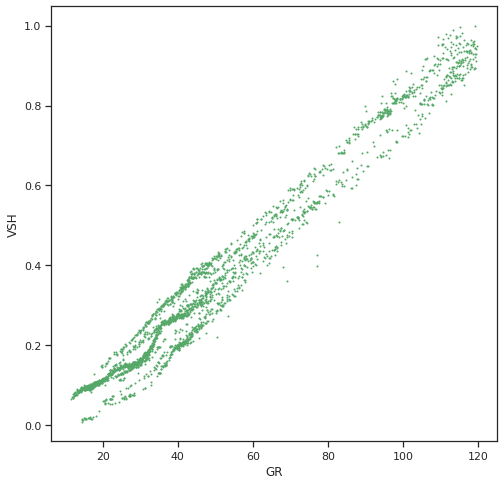

In [ ]:
# Filter data points
fit_df = create_fit_df( test_well_idx, train_df_list_vsh_mod )
plot_scatter_vsh( fit_df )

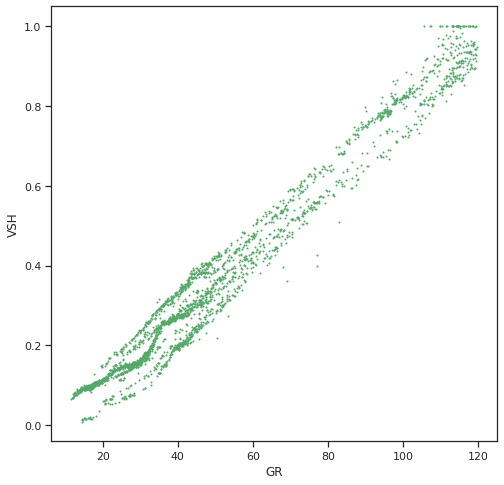

In [ ]:
# Display whole dataset for current well
plot_scatter_whole( train_df_list_vsh[test_well_idx] )

In [ ]:
# Number of line to fit
num_lines = 4

Best score 0.13636363636363635 Data points 396
Best score 0.15771349862258954 Data points 458
Best score 0.17045454545454544 Data points 495
Best score 0.20557851239669422 Data points 597
Best score 0.21694214876033058 Data points 630
Best score 0.23725895316804407 Data points 689
Best score 0.24070247933884298 Data points 699
Best score 0.24621212121212122 Data points 715
Best score 0.24862258953168045 Data points 722
Best score 0.25 Data points 726
Best score 0.25172176308539945 Data points 731
m [0.00455971] c 0.022620781190003575

Best score 0.04601932811780948 Data points 100
Best score 0.06442705936493327 Data points 140
Best score 0.07317073170731707 Data points 159
Best score 0.1155085135757018 Data points 251
Best score 0.13529682466635987 Data points 294
Best score 0.1421997238840313 Data points 309
Best score 0.14450069028992177 Data points 314
Best score 0.14772204325816843 Data points 321
Best score 0.17395306028531984 Data points 378
Best score 0.17441325356649792 Data po

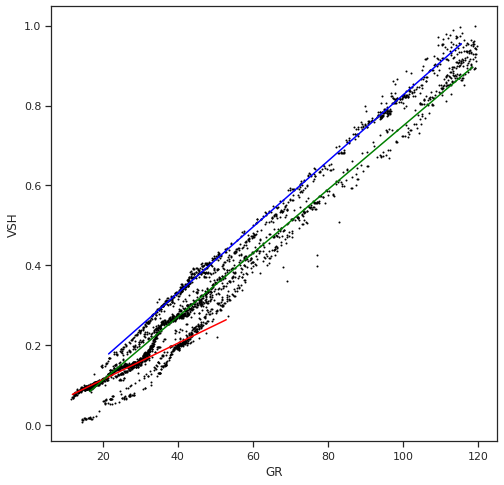

In [ ]:
num_lines = 3

res_x_list, res_y_list, res_z_list, dis_x_list, dis_y_list, dis_z_list, best_reg_list = extract_lines_vsh( fit_df, tol=0.0087 )    
plot_preds( dis_x_list, dis_y_list, best_reg_list, fit_df )

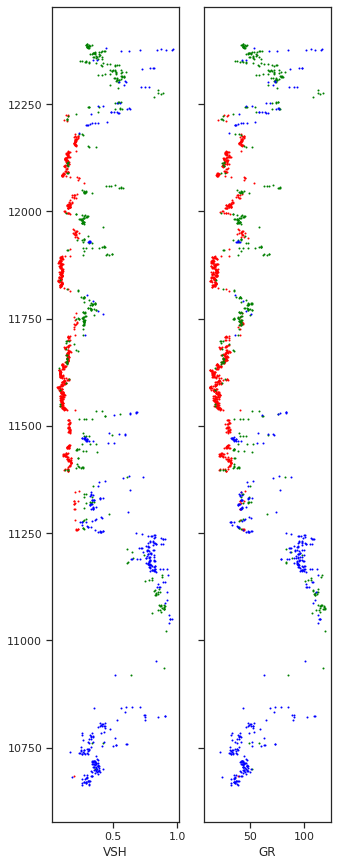

In [ ]:
line_fit_logs( dis_x_list, dis_y_list, dis_z_list )

In [ ]:
train_df_list_vsh_mod = set_facies_id( train_df_list_vsh_mod, test_well_idx, dis_z_list )

In [ ]:
train_well_104 = train_df_list_vsh_mod[0]

In [ ]:
train_well_104['VSH_to_GR'] = train_well_104['VSH']/train_well_104['GR']

In [ ]:
train_well_104.groupby('FACIES').count()

,WELLNUM,DEPTH,DTC,DTS,CALI,DEN,DENC,GR,NEU,PEF,RDEP,RMED,VSH,VSH_to_GR,M
FACIES,,,,,,,,,,,,,,,
0,1413,1413,1384,0,1413,1413,1413,1413,1413,1413,1413,1413,1413,1413,1413
1,731,731,731,0,731,731,731,731,731,731,731,731,731,731,731
2,403,403,362,0,403,403,403,403,403,403,403,403,403,403,403
3,396,396,387,0,396,396,396,396,396,396,396,396,396,396,396


In [ ]:
def group_M(x):
  if x == 1 :
    return 0.00455971
  elif x == 2:
    return 0.00795858
  elif x == 3:
    return 0.00826
  else:
    return 0

train_well_104['M'] = train_well_104['FACIES'].apply(group_M)

def group_C(x):
  if x == 1 :
    return 0.022620781190003575
  elif x == 2:
    return -0.047070583953962686
  elif x == 3:
    return 0.00017187975342281003
  else:
    return 0

train_well_104['C'] = train_well_104['FACIES'].apply(group_C)

In [ ]:
def group_C(x):
  if x == 1 :
    return 0.022620781190003575
  elif x == 2:
    return -0.047070583953962686
  elif x == 3:
    return 0.00017187975342281003
  else:
    return 0

train_well_104['C'] = train_well_104['FACIES'].apply(group_C)

In [ ]:
train_well_104['New_VSH'] = (train_well_104['M']*train_well_104['GR']) + train_well_104['C']
train_well_104 = train_well_104[train_well_104['New_VSH'] != 0]

In [ ]:
# train_well_104 = train_well_104[train_well_104['New_VSH'] != 0]

In [ ]:
train_well_104 

,WELLNUM,DEPTH,DTC,DTS,CALI,DEN,DENC,GR,NEU,PEF,RDEP,RMED,VSH,FACIES,VSH_to_GR,M,C,New_VSH
8,104,10662.5,67.1753,NaN,8.420227,2.621499,0.133489,32.1685,0.102445,8.992697,1.111943,1.106121,0.257081,3,0.007992,0.008260,0.000172,0.265884
11,104,10664.0,71.7615,NaN,8.551704,2.602503,0.119976,38.5500,0.129704,8.162967,0.997196,1.022077,0.310651,3,0.008058,0.008260,0.000172,0.318595
12,104,10664.5,74.3292,NaN,8.573069,2.613642,0.126093,37.3812,0.129042,8.235380,0.824864,0.842183,0.310081,3,0.008295,0.008260,0.000172,0.308941
18,104,10667.5,68.1535,NaN,8.491500,2.603072,0.063100,32.0585,0.112393,6.563143,1.118640,1.062315,0.261257,3,0.008149,0.008260,0.000172,0.264975
19,104,10668.0,69.7512,NaN,8.456420,2.593501,0.059450,35.1779,0.122738,6.395062,1.004144,0.965664,0.293498,3,0.008343,0.008260,0.000172,0.290741
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2926,104,12387.5,NaN,NaN,8.534575,2.437211,0.051366,44.8135,0.142086,3.652311,0.041938,0.043950,0.312902,2,0.006982,0.007959,-0.047071,0.309581
2928,104,12388.5,NaN,NaN,8.528750,2.431025,0.043805,41.8059,0.136000,3.022752,0.211379,0.176194,0.293935,2,0.007031,0.007959,-0.047071,0.285645
2929,104,12389.0,NaN,NaN,8.517250,2.441037,0.038128,41.6169,0.134735,3.032563,0.128508,0.177066,0.291599,2,0.007007,0.007959,-0.047071,0.284141
2930,104,12389.5,NaN,NaN,8.533512,2.454286,0.034947,42.6726,0.131458,3.057496,0.215386,0.219256,0.299538,2,0.007019,0.007959,-0.047071,0.292543


In [ ]:
# train_well_104['New_VSH'] = (train_well_104['M']*train_well_104['GR']) + train_well_104['C']
# train_well_104 = train_well_104[train_well_104['New_VSH'] != 0]
train_well_104 = train_well_104[['WELLNUM','DEPTH','New_VSH']]

In [ ]:
# train_well_104['New_VSH'] = (train_well_104['M']*train_well_104['GR']) + train_well_104['C']
# train_well_104 = train_well_104[train_well_104['New_VSH'] != 0]
# train_well_104 = train_well_104[['WELLNUM','DEPTH','New_VSH']]
train_well_104.to_csv('train_well_104.csv', index=False)
files.download('train_well_104.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Well 100

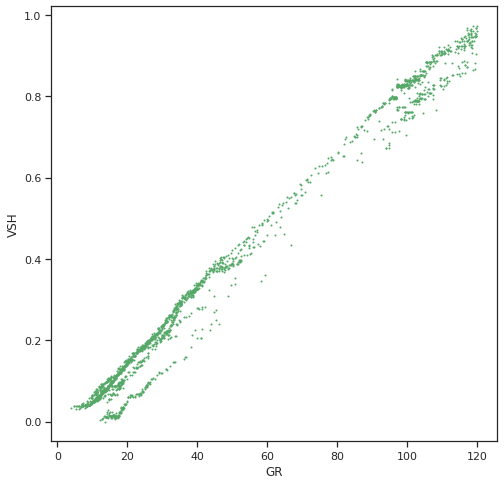

In [ ]:
test_well_idx = 1

# Filter data points
fit_df = create_fit_df( test_well_idx, train_df_list_vsh_mod )
plot_scatter_vsh( fit_df )

Best score 0.019991115059973346 Data points 45
Best score 0.08840515326521546 Data points 199
Best score 0.36561528209684585 Data points 823
Best score 0.3998223011994669 Data points 900
Best score 0.40693025322079074 Data points 916
Best score 0.4135939582407819 Data points 931
Best score 0.4238116392714349 Data points 954
Best score 0.4278098622834296 Data points 963
Best score 0.42958685028876054 Data points 967
Best score 0.44380275433140826 Data points 999
Best score 0.4486894713460684 Data points 1010
Best score 0.4491337183474012 Data points 1011
m [0.00869438] c -0.033861478696242786

Best score 0.09032258064516129 Data points 112
Best score 0.1282258064516129 Data points 159
Best score 0.17580645161290323 Data points 218
Best score 0.1967741935483871 Data points 244
Best score 0.2064516129032258 Data points 256
Best score 0.2129032258064516 Data points 264
Best score 0.2564516129032258 Data points 318
Best score 0.27903225806451615 Data points 346
Best score 0.2895161290322580

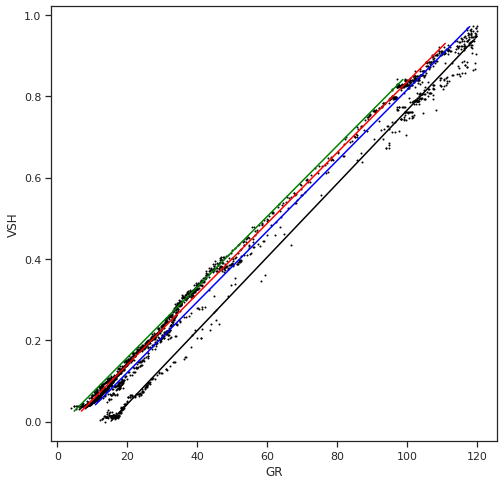

In [ ]:
num_lines = 4

res_x_list, res_y_list, res_z_list, dis_x_list, dis_y_list, dis_z_list, best_reg_list = extract_lines_vsh( fit_df, tol=0.01 )    
plot_preds( dis_x_list, dis_y_list, best_reg_list, fit_df )

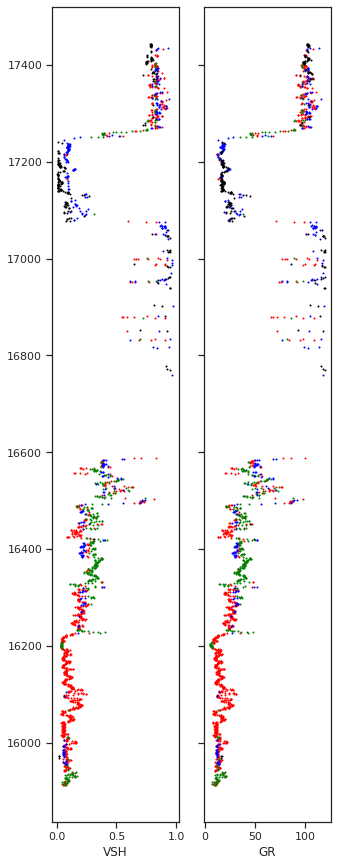

In [ ]:
line_fit_logs( dis_x_list, dis_y_list, dis_z_list )

In [ ]:
train_df_list_vsh_mod = set_facies_id( train_df_list_vsh_mod, test_well_idx, dis_z_list )
train_well_100 = train_df_list_vsh_mod[1]
train_well_100.groupby('FACIES').count()

,WELLNUM,DEPTH,DTC,DTS,CALI,DEN,DENC,GR,NEU,PEF,RDEP,RMED,VSH
FACIES,,,,,,,,,,,,,
0,482,482,454,329,482,482,482,482,482,482,482,482,482
1,941,941,928,863,941,941,941,941,939,941,941,941,941
2,377,377,364,220,377,377,377,377,377,377,377,377,377
3,262,262,261,224,262,262,262,262,260,262,262,262,262
4,201,201,162,155,201,201,201,201,201,201,201,201,201


In [ ]:
def group_M(x):
  if x == 1 :
    return 0.00879188
  elif x == 2:
    return 0.00832172
  elif x == 3:
    return 0.00857826
  elif x == 4:
    return 0.0090069
  else:
    return 0

train_well_100['M'] = train_well_100['FACIES'].apply(group_M)

def group_C(x):
  if x == 1 :
    return -0.03593694797235342
  elif x == 2:
    return -0.006323532380861696
  elif x == 3:
    return -0.04992348327262086
  elif x == 4:
    return -0.13660138362539243
  else:
    return 0

train_well_100['C'] = train_well_100['FACIES'].apply(group_C)

In [ ]:
train_well_100['New_VSH'] = (train_well_100['M']*train_well_100['GR']) + train_well_100['C']
train_well_100 = train_well_100[train_well_100['New_VSH'] != 0]
train_well_100 = train_well_100[['WELLNUM','DEPTH','New_VSH']]
train_well_100.to_csv('train_well_100.csv', index=False)
files.download('train_well_100.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Well 101

In [ ]:
train_df_list_vsh_mod[2]

,WELLNUM,DEPTH,DTC,DTS,CALI,DEN,DENC,GR,NEU,PEF,RDEP,RMED,VSH,FACIES,M,C,New_VSH
0,101,10177.5,77.7654,NaN,8.70542,NaN,NaN,46.2400,0.313380,NaN,NaN,NaN,0.291021,0,0.000000,0.000000,0.000000
1,101,10178.0,82.2797,NaN,8.70232,NaN,NaN,46.8203,0.317550,NaN,NaN,NaN,0.331368,1,0.009033,-0.099913,0.323017
2,101,10178.5,85.8294,NaN,8.70824,NaN,NaN,48.4165,0.329425,NaN,NaN,NaN,0.342481,1,0.009033,-0.099913,0.337435
3,101,10179.0,90.2274,NaN,8.69888,NaN,NaN,54.8328,0.335807,NaN,NaN,NaN,0.402821,1,0.009033,-0.099913,0.395394
4,101,10179.5,89.9093,NaN,8.70162,NaN,NaN,63.8642,0.345120,NaN,NaN,NaN,0.471737,1,0.009033,-0.099913,0.476975
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2628,101,11498.0,NaN,NaN,8.78712,2.319195,0.041645,80.4232,0.226649,3.302806,-0.127009,-0.193624,0.593342,2,0.005810,0.125820,0.593046
2629,101,11498.5,NaN,NaN,8.78787,2.350981,0.041956,81.3912,0.219035,3.271460,-0.148220,-0.085768,0.601871,2,0.005810,0.125820,0.598670
2630,101,11499.0,NaN,NaN,8.81450,2.386609,0.032749,83.4233,0.223217,3.303865,0.170612,0.076220,0.605578,2,0.005810,0.125820,0.610476
2631,101,11499.5,NaN,NaN,8.81250,2.415982,0.028567,81.9957,0.204803,3.388157,0.476060,0.430067,0.622688,0,0.000000,0.000000,0.000000


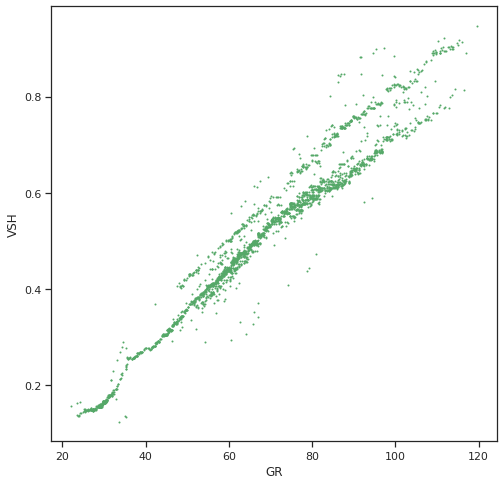

In [ ]:
test_well_idx = 2

# Filter data points
fit_df = create_fit_df( test_well_idx, train_df_list_vsh_mod )
plot_scatter_vsh( fit_df )

Best score 0.3987846562856058 Data points 1050
Best score 0.5377895936194454 Data points 1416
Best score 0.5415875427269274 Data points 1426
Best score 0.5529813900493733 Data points 1456
Best score 0.5560197493353589 Data points 1464
Best score 0.5567793391568553 Data points 1466
Best score 0.5575389289783517 Data points 1468
m [0.00870047] c -0.08472963418247603

Best score 0.14506437768240343 Data points 169
Best score 0.27811158798283264 Data points 324
Best score 0.3244635193133047 Data points 378
Best score 0.39399141630901285 Data points 459
Best score 0.4 Data points 466
Best score 0.4669527896995708 Data points 544
Best score 0.4703862660944206 Data points 548
Best score 0.47296137339055794 Data points 551
Best score 0.4738197424892704 Data points 552
Best score 0.47639484978540775 Data points 555
Best score 0.47725321888412015 Data points 556
Best score 0.4781115879828326 Data points 557
Best score 0.4798283261802575 Data points 559
m [0.00586317] c 0.11981076025402909

Best 

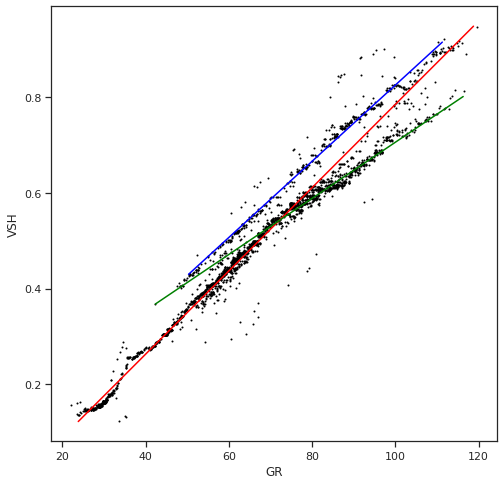

In [ ]:
num_lines = 3

res_x_list, res_y_list, res_z_list, dis_x_list, dis_y_list, dis_z_list, best_reg_list = extract_lines_vsh( fit_df, tol=0.016 )    
plot_preds( dis_x_list, dis_y_list, best_reg_list, fit_df )

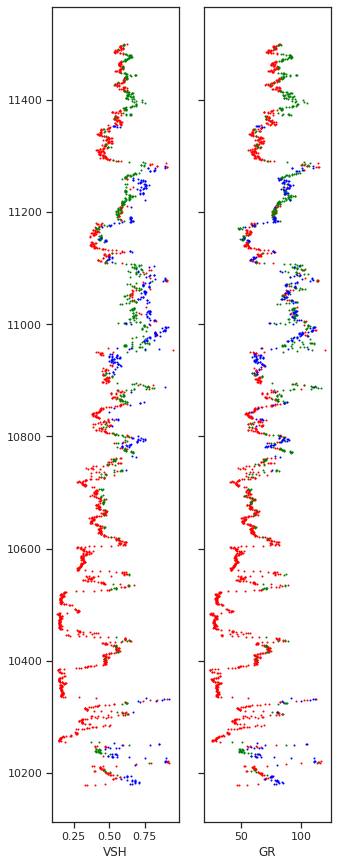

In [ ]:
line_fit_logs( dis_x_list, dis_y_list, dis_z_list )

In [ ]:
train_df_list_vsh_mod = set_facies_id( train_df_list_vsh_mod, test_well_idx, dis_z_list )
train_well_101 = train_df_list_vsh_mod[2]
train_well_101.groupby('FACIES').count()

,WELLNUM,DEPTH,DTC,DTS,CALI,DEN,DENC,GR,NEU,PEF,RDEP,RMED,VSH,M,C,New_VSH
FACIES,,,,,,,,,,,,,,,,
0,277,277,260,0,277,259,259,277,277,259,261,261,277,277,277,277
1,1468,1468,1211,0,1468,1428,1428,1468,1468,1428,1430,1430,1468,1468,1468,1468
2,559,559,428,0,559,554,554,559,559,554,555,555,559,559,559,559
3,329,329,323,0,329,310,310,329,329,310,310,310,329,329,329,329


In [ ]:
def group_M(x):
  if x == 1 :
    return 0.00870047
  elif x == 2:
    return 0.00586317
  elif x == 3:
    return 0.00795873
  else:
    return 0

train_well_101['M'] = train_well_101['FACIES'].apply(group_M)

def group_C(x):
  if x == 1 :
    return -0.08472963418247603
  elif x == 2:
    return 0.11981076025402909
  elif x == 3:
    return 0.02970121491744626
  else:
    return 0

train_well_101['C'] = train_well_101['FACIES'].apply(group_C)

In [ ]:
train_well_101['New_VSH'] = (train_well_101['M']*train_well_101['GR']) + train_well_101['C']
train_well_101 = train_well_101[train_well_101['New_VSH'] != 0]
# train_well_101 = train_well_101[['WELLNUM','DEPTH','New_VSH']]
# train_well_101.to_csv('train_well_101_2.csv', index=False)
# files.download('train_well_101_2.csv')

In [ ]:
train_well_101 = train_well_101[['WELLNUM','DEPTH','New_VSH']]
train_well_101.to_csv('train_well_101_2.csv', index=False)
files.download('train_well_101_2.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

###Well 103

In [ ]:
train_df_list_vsh_mod[3]

,WELLNUM,DEPTH,DTC,DTS,CALI,DEN,DENC,GR,NEU,PEF,RDEP,RMED,VSH
0,103,10349.5,91.6049,164.099,8.49200,2.460403,0.047150,117.4860,0.344907,5.604778,0.491172,0.483068,0.894060
1,103,10350.0,92.6125,163.342,8.47909,2.464919,0.046116,115.1110,0.306518,5.613291,0.453817,0.462671,0.892087
2,103,10350.5,92.2028,162.078,8.54425,2.462558,0.040541,115.6680,0.336785,5.547937,0.510588,0.505268,0.874873
3,103,10351.0,92.2846,161.284,8.52932,2.453183,0.036771,118.4830,0.319169,5.574705,0.525249,0.526024,0.892174
4,103,10355.5,93.2281,170.499,8.56125,2.454503,0.037265,118.7500,0.342596,5.425302,0.723060,0.632016,0.892174
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2165,103,11464.5,NaN,NaN,8.72324,2.497218,0.008755,55.2710,0.133333,2.986545,0.489714,0.468966,0.430022
2166,103,11465.0,NaN,NaN,8.73250,2.501415,0.007408,54.4372,0.138164,3.204859,0.571657,0.512590,0.422373
2167,103,11465.5,NaN,NaN,8.76964,2.527696,0.026643,53.1210,0.127003,3.479808,0.547451,0.518079,0.442363
2168,103,11466.0,NaN,NaN,8.76054,2.529146,0.045622,53.5670,0.134072,4.112808,0.536523,0.534099,0.448792


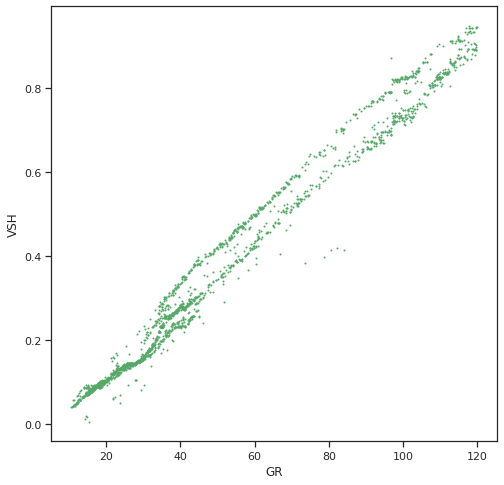

In [ ]:
test_well_idx = 3

# Filter data points
fit_df = create_fit_df( test_well_idx, train_df_list_vsh_mod )
plot_scatter_vsh( fit_df )

Best score 0.11658986175115207 Data points 253
Best score 0.12119815668202764 Data points 263
Best score 0.1327188940092166 Data points 288
Best score 0.13732718894009216 Data points 298
Best score 0.24147465437788018 Data points 524
Best score 0.24193548387096775 Data points 525
Best score 0.24285714285714285 Data points 527
m [0.00793673] c -0.047206133266757155

Best score 0.08216676810712112 Data points 135
Best score 0.11442483262325015 Data points 188
Best score 0.16555082166768106 Data points 272
Best score 0.17711503347534996 Data points 291
Best score 0.18807060255629945 Data points 309
Best score 0.18867924528301888 Data points 310
Best score 0.18928788800973828 Data points 311
Best score 0.1898965307364577 Data points 312
m [0.00646928] c -0.025490498492187597

Best score 0.0405709992486852 Data points 54
Best score 0.06836964688204357 Data points 91
Best score 0.10518407212622088 Data points 140
Best score 0.14274981217129978 Data points 190
Best score 0.14350112697220135 D

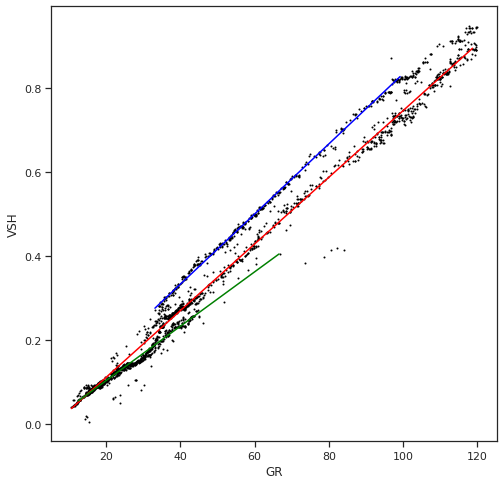

In [ ]:
num_lines = 3

res_x_list, res_y_list, res_z_list, dis_x_list, dis_y_list, dis_z_list, best_reg_list = extract_lines_vsh( fit_df, tol=0.005 )    
plot_preds( dis_x_list, dis_y_list, best_reg_list, fit_df )

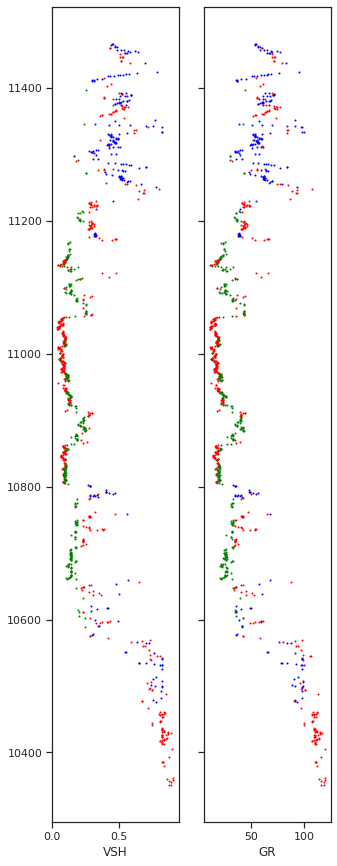

In [ ]:
line_fit_logs( dis_x_list, dis_y_list, dis_z_list )

In [ ]:
train_df_list_vsh_mod = set_facies_id( train_df_list_vsh_mod, test_well_idx, dis_z_list )
train_well_103 = train_df_list_vsh_mod[3]
train_well_103.groupby('FACIES').count()

,WELLNUM,DEPTH,DTC,DTS,CALI,DEN,DENC,GR,NEU,PEF,RDEP,RMED,VSH
FACIES,,,,,,,,,,,,,
0,1109,1109,1062,950,1109,1109,1109,1109,1109,1109,1109,1109,1109
1,527,527,518,494,527,527,527,527,527,527,527,527,527
2,312,312,312,307,312,312,312,312,312,312,312,312,312
3,222,222,205,162,222,222,222,222,222,222,222,222,222


In [ ]:
def group_M(x):
  if x == 1 :
    return 0.00793673
  elif x == 2:
    return 0.00646928
  elif x == 3:
    return 0.00834863
  else:
    return 0

train_well_103['M'] = train_well_103['FACIES'].apply(group_M)

def group_C(x):
  if x == 1 :
    return -0.047206133266757155
  elif x == 2:
    return -0.025490498492187597
  elif x == 3:
    return -0.000687422395919346
  else:
    return 0

train_well_103['C'] = train_well_103['FACIES'].apply(group_C)

In [ ]:
train_well_103['New_VSH'] = (train_well_103['M']*train_well_103['GR']) + train_well_103['C']
train_well_103 = train_well_103[train_well_103['New_VSH'] != 0]
train_well_103 = train_well_103[['WELLNUM','DEPTH','New_VSH']]
train_well_103.to_csv('train_well_103.csv', index=False)
files.download('train_well_103.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>